In [1]:
import pandas as pd
import numpy as np
import itertools as it

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.ticker as mtick

import urllib.request
import json

plt.rc('axes', axisbelow=True)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

%matplotlib inline

# Daily COVID-19 plots

In [2]:
all_state_names = {'ak': 'Alaska', 'al': 'Alabama', 'ar': 'Arkansas',
                   'as': 'American Samoa',  'az': 'Arizona',
                   'ca': 'California', 'co': 'Colorado',
                   'ct': 'Connecticut', 'dc': 'District of Columbia',
                   'de': 'Delaware', 'fl': 'Florida', 'ga': 'Georgia',
                   'gu': 'Guam', 'hi': 'Hawaii', 'ia': 'Iowa',
                   'id': 'Idaho', 'il': 'Illinois', 'in': 'Indiana',
                   'ks': 'Kansas', 'ky': 'Kentucky', 'la': 'Louisiana',
                   'ma': 'Massachusetts', 'md': 'Maryland', 'me': 'Maine',
                   'mi': 'Michigan', 'mn': 'Minnesota', 'mo': 'Missouri',
                   'mp': 'Northern Mariana Islands', 'ms': 'Mississippi',
                   'mt': 'Montana', 'nc': 'North Carolina',
                   'nd': 'North Dakota', 'ne': 'Nebraska',
                   'nh': 'New Hampshire', 'nj': 'New Jersey',
                   'nm': 'New Mexico', 'nv': 'Nevada', 'ny': 'New York',
                   'oh': 'Ohio', 'ok': 'Oklahoma', 'or': 'Oregon',
                   'pa': 'Pennsylvania', 'pr': 'Puerto Rico',
                   'ri': 'Rhode Island', 'sc': 'South Carolina',
                   'sd': 'South Dakota', 'tn': 'Tennessee', 'tx': 'Texas',
                   'ut': 'Utah', 'va': 'Virginia',
                   'vi': 'Virgin Islands', 'vt': 'Vermont',
                   'wa': 'Washington', 'wi': 'Wisconsin',
                   'wv': 'West Virginia', 'wy': 'Wyoming'}

all_state_ids = {'01': 'al', '02': 'ak', '04': 'az', '05': 'ar',
                 '06': 'ca', '08': 'co', '09': 'ct', '10': 'de',
                 '11': 'dc', '12': 'fl', '13': 'ga', '15': 'hi',
                 '16': 'id', '17': 'il', '18': 'in', '19': 'ia',
                 '20': 'ks', '21': 'ky', '22': 'la', '23': 'me',
                 '24': 'md', '25': 'ma', '26': 'mi', '27': 'mn',
                 '28': 'ms', '29': 'mo', '30': 'mt', '31': 'ne',
                 '32': 'nv', '33': 'nh', '34': 'nj', '35': 'nm',
                 '36': 'ny', '37': 'nc', '38': 'nd', '39': 'oh',
                 '40': 'ok', '41': 'or', '42': 'pa', '44': 'ri',
                 '45': 'sc', '46': 'sd', '47': 'tn', '48': 'tx',
                 '49': 'ut', '50': 'vt', '51': 'va', '53': 'wa',
                 '54': 'wv', '55': 'wi', '56': 'wy', "60": 'as',
                 "66": 'gu', "72": 'pr', '78': 'vi', '69': 'mp'}

all_ids_state = {j:i for i,j in all_state_ids.items()}

state_posx = {'ak': (0, 0), 'me': (0, 10),'gu': (7, 0), 'vi': (7, 9), 'pr': (7, 8), 'mp': (7, 1),
              'vt': (1, 9), 'nh': (1, 10),'wa': (2, 0), 'id': (2, 1), 'mt': (2, 2), 'nd': (2, 3), 'mn': (2, 4),
              'il': (2, 5), 'wi': (2, 6), 'mi': (2, 7), 'ny': (2, 8), 'ri': (2, 9), 'ma': (2, 10),'or': (3, 0),
              'nv': (3, 1), 'wy': (3, 2), 'sd': (3, 3), 'ia': (3, 4), 'in': (3, 5), 'oh': (3, 6), 'pa': (3, 7),
              'nj': (3, 8), 'ct': (3, 9), 'ca': (4, 0), 'ut': (4, 1), 'co': (4, 2), 'ne': (4, 3), 'mo': (4, 4),
              'ky': (4, 5), 'wv': (4, 6), 'va': (4, 7), 'md': (4, 8), 'de': (4, 9), 'az': (5, 1), 'nm': (5, 2), 
              'ks': (5, 3), 'ar': (5, 4), 'tn': (5, 5), 'nc': (5, 6), 'sc': (5, 7), 'dc': (5, 8), 'ok': (6, 3),
              'la': (6, 4), 'ms': (6, 5), 'al': (6, 6), 'ga': (6, 7), 'hi': (6, 0), 'tx': (7, 3), 'fl': (7, 7)}

In [3]:
month_dict = {'01':'January','02':'February','03':'March','04':'April','05':'May','06':'June',
              '07':'July','08':'August','09':'September','10':'October','11':'November','12':'December'}

today = str(dt.datetime.date(dt.datetime.now()))

# make DATE_DF, a simple dataframe with dates, weekdays, and weeknums
weekday_mapping = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}

alldates = pd.date_range(start='2020-01-01', end='2021-12-31').tolist()
datelist = [str(i.date()) for i in alldates]
weekdays = [weekday_mapping[i.date().weekday()] for i in alldates]
weeklist = [i//7 for i in range(len(alldates))]
DATE_DF = pd.DataFrame({'date':datelist,'day':weekdays,'week':weeklist})
DATE_DF = DATE_DF.loc[DATE_DF['date']<=today].copy()
DATERANGE = DATE_DF['date'].tolist()
dates = DATERANGE.copy()

In [4]:
out = []

for st in all_state_names.keys():
    print(all_state_names[st], dt.datetime.now())
    url_state_i = 'https://covid.cdc.gov/covid-data-tracker/COVIDData/'+\
           'getAjaxData?id=integrated_county_timeseries_state_%s_external'%st.upper()
    try:
        with urllib.request.urlopen(url_state_i) as url_i:
            data_i = json.loads(url_i.read().decode())

        st_i = pd.DataFrame(data_i['integrated_county_timeseries_external_data'])
        out.append(st_i)
    except:
        print('\t','could not scrape')

Alaska 2021-03-07 22:27:03.097233
Alabama 2021-03-07 22:27:06.506709
Arkansas 2021-03-07 22:27:15.132804
American Samoa 2021-03-07 22:27:23.450751
	 could not scrape
Arizona 2021-03-07 22:27:23.633385
California 2021-03-07 22:27:24.664261
Colorado 2021-03-07 22:27:31.934111
Connecticut 2021-03-07 22:27:39.977991
District of Columbia 2021-03-07 22:27:41.442705
Delaware 2021-03-07 22:27:41.778491
Florida 2021-03-07 22:27:42.940734
Georgia 2021-03-07 22:27:55.894762
Guam 2021-03-07 22:28:17.859913
	 could not scrape
Hawaii 2021-03-07 22:28:18.004343
Iowa 2021-03-07 22:28:19.183785
Idaho 2021-03-07 22:28:30.844583
Illinois 2021-03-07 22:28:38.540975
Indiana 2021-03-07 22:28:57.393140
Kansas 2021-03-07 22:29:09.384007
Kentucky 2021-03-07 22:29:23.615277
Louisiana 2021-03-07 22:29:37.076172
Massachusetts 2021-03-07 22:29:44.468786
Maryland 2021-03-07 22:29:45.435498
Maine 2021-03-07 22:29:48.312424
Michigan 2021-03-07 22:29:55.794895
Minnesota 2021-03-07 22:30:04.783847
Missouri 2021-03-07 2

In [5]:
tdf = pd.concat(out)
last_date = tdf.date.max()[:10]
tdf['fips_code'] = ("0"+tdf['fips_code'].astype(str).str[:]).str[-5:]
tdf['date'] = tdf['date'].str[:10]
tdf = tdf.sort_values(['fips_code','date']).reset_index().iloc[:,1:]
pd.set_option('display.max_columns', 50)

print(tdf.columns)
tdf.tail()

Index(['fips_code', 'state', 'state_name', 'cbsa_code', 'county',
       'new_cases_week_over_week_percent_change',
       'new_cases_7_day_rolling_average',
       'new_cases_per_100k_7_day_rolling_average',
       'new_deaths_7_day_rolling_average',
       'new_deaths_week_over_week_percent_change',
       'new_deaths_per_100k_7_day_rolling_average',
       'daily_cli_7_day_rolling_average',
       'daily_cli_percentage_7_day_rolling_average',
       'daily_ili_percentage_7_day_rolling_average',
       'new_test_results_reported',
       'new_test_results_reported_7_day_rolling_average',
       'percent_new_test_results_reported_positive_7_day_rolling_average',
       'percent_positive_7_day',
       'total_test_results_reported_week_over_week_count_change',
       'testing_suppressed', 'total_hospitals_reporting',
       'admissions_covid_confirmed_last_7_days',
       'admissions_covid_confirmed_7_day_rolling_average',
       'admissions_covid_confirmed_last_7_days_per_100_beds',
 

,fips_code,state,state_name,cbsa_code,county,new_cases_week_over_week_percent_change,new_cases_7_day_rolling_average,new_cases_per_100k_7_day_rolling_average,new_deaths_7_day_rolling_average,new_deaths_week_over_week_percent_change,new_deaths_per_100k_7_day_rolling_average,daily_cli_7_day_rolling_average,daily_cli_percentage_7_day_rolling_average,daily_ili_percentage_7_day_rolling_average,new_test_results_reported,new_test_results_reported_7_day_rolling_average,percent_new_test_results_reported_positive_7_day_rolling_average,percent_positive_7_day,total_test_results_reported_week_over_week_count_change,testing_suppressed,total_hospitals_reporting,admissions_covid_confirmed_last_7_days,admissions_covid_confirmed_7_day_rolling_average,admissions_covid_confirmed_last_7_days_per_100_beds,admissions_covid_confirmed_week_over_week_percent_change,percent_adult_inpatient_beds_used_confirmed_covid,percent_adult_inpatient_beds_used_confirmed_covid_week_over_week_absolute_change,hospitals_included_in_percent_adult_inpatient_beds_used_confirmed_covid,percent_adult_icu_beds_used_confirmed_covid,percent_adult_icu_beds_used_confirmed_covid_week_over_week_absolute_change,hospitals_included_in_percent_adult_icu_beds_used_confirmed_covid,cbsa_daily_cli_7_day_rolling_average,cbsa_daily_cli_percentage_7_day_rolling_average,cbsa_daily_ili_7_day_rolling_average,cbsa_daily_ili_percentage_7_day_rolling_average,date,report_date_window_start,report_date_window_end,community_transmission_level
1286789,72153,PR,Puerto Rico,None,Yauco Municipio,None,1.00,None,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,None,None,None,0.0,0.00,0.00,-1.0,0.0097,-0.0218,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-03-01,2021-02-23T00:00:00,2021-03-01T00:00:00,moderate
1286790,72153,PR,Puerto Rico,None,Yauco Municipio,None,1.00,None,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,None,None,None,1.0,0.14,1.54,-0.5,0.0000,-0.0291,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-03-02,2021-02-24T00:00:00,2021-03-02T00:00:00,moderate
1286791,72153,PR,Puerto Rico,None,Yauco Municipio,None,0.71,None,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,None,None,None,1.0,0.14,1.55,-0.5,0.0000,-0.0315,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-03-03,2021-02-25T00:00:00,2021-03-03T00:00:00,moderate
1286792,72153,PR,Puerto Rico,None,Yauco Municipio,None,0.43,None,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,None,None,None,1.0,0.14,1.52,0.0,0.0000,-0.0291,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-03-04,2021-02-26T00:00:00,2021-03-04T00:00:00,low
1286793,72153,PR,Puerto Rico,None,Yauco Municipio,None,0.43,None,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,0.0,0.0,None,None,None,1.0,0.14,1.50,0.0,0.0000,-0.0242,None,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-03-05,2021-02-27T00:00:00,2021-03-05T00:00:00,low


In [6]:
up_col = '#224c88'
down_col = 'lightseagreen'
vdown_col = 'skyblue'
low_col = 'tan'

lw = 3

In [7]:
month_dict = {'01':'Jan','02':'Feb','03':'Mar','04':'Apr','05':'May','06':'Jun',
              '07':'Jul','08':'Aug','09':'Sep','10':'Oct','11':'Nov','12':'Dec'}
date_dict = dict(zip(DATE_DF['date'].values,list(range(DATE_DF.shape[0]))))

state_pop = pd.read_csv('https://raw.githubusercontent.com/CivilServiceUSA/us-states/master/data/states.csv')
state_pop = state_pop[['state','population']].copy()
extra_states = ['District of Columbia','United States','Puerto Rico','Virgin Islands',
                'Guam','Northern Mariana Islands']
extra_populs = [692683,330854067,3193694,106631,167294,57216]
state_pop = pd.concat([state_pop,
                       pd.DataFrame({'state':extra_states,
                                     'population':extra_populs})]).reset_index().iloc[:,1:]

In [8]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import urllib.request
import json

# use creds to create a client to interact with the Google Drive API
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('../client_secret.json', scope)
client = gspread.authorize(creds)

mass_data = client.open("new_variants")
variant_data = mass_data.worksheet('timeseries')

variant_df = pd.DataFrame(variant_data.get_all_records())
variant_df['total_cases_b117'] = variant_df['total_cases_b117'].astype(float)
variant_df['total_cases_p1'] = variant_df['total_cases_p1'].astype(float)
variant_df['total_cases_b1351'] = variant_df['total_cases_b1351'].astype(float)

url_variant = 'https://www.cdc.gov/coronavirus/2019-ncov/modules/transmission/variant-cases.json'

with urllib.request.urlopen(url_variant) as url_i:
    data_i = json.loads(url_i.read().decode())

mon_di = {j[:3]:i for i,j in month_dict.items()}

r = urllib.request.urlopen('https://www.cdc.gov/coronavirus/2019-ncov/transmission/variant-cases.html')
date_cdc = [i for i in r.readlines() if 'cdc:last_updated' in str(i)][0]
date_cdc = str(str(date_cdc).split('content="')[1]).split('"')[0]

cdc_date = date_cdc.split(' ')[2] + '-' +\
           mon_di[date_cdc.split(' ')[0].replace('.','')] + '-' +\
           ("0"+date_cdc.split(' ')[1].replace(',',''))[-2:]

new_var = pd.DataFrame(data_i['data'])

new_var = new_var.loc[new_var['filter'] == 'Variant B.1.1.7'].copy()
new_var = new_var.rename(columns={'B.1.1.7 Variant ':'total_cases_b117',
                        'P.1 Variant ':'total_cases_p1',
                        'B.1.351 Variant ':'total_cases_b1351', 'State':'state'})
new_var['date'] = cdc_date
new_var = new_var[['date','state','total_cases_b117','total_cases_p1','total_cases_b1351']].copy()
new_var['total_cases_b117'] = np.nan_to_num(new_var['total_cases_b117'])
new_var['total_cases_p1'] = np.nan_to_num(new_var['total_cases_p1'])
new_var['total_cases_b1351'] = np.nan_to_num(new_var['total_cases_b1351'])
# new_var

rem_states = ['AS', 'GU', 'MH', 'FM', 'MP', 'PW', 'PR', 'VI']

if variant_df['date'].max()<new_var['date'].max():
    variant_df = pd.concat([variant_df,new_var])
variant_df = variant_df.loc[~variant_df['state'].isin(rem_states)].copy()
variant_df.loc[variant_df['state']=='District of Columbia', 'state'] = 'DC'
variant_df = variant_df.drop_duplicates().sort_values(['date','state']).reset_index().iloc[:,1:]

finish = variant_df.shape[0]
datUp = np.array([variant_df['date'].tolist(), variant_df['state'].tolist(),
                  variant_df['total_cases_b117'].tolist(),
                  variant_df['total_cases_p1'].tolist(),
                  variant_df['total_cases_b1351'].tolist()]).T.tolist()
datUp = [[str(i[0]),str(i[1]),int(float(i[2])),int(float(i[3])),int(float(i[4]))] for i in datUp]

variant_data.update('A%i:E%i'%(2,2+finish), datUp)

variant_df = variant_df.merge(DATE_DF[['week','date']], how='left', on='date')
var_w_df = variant_df.groupby(['state','week']).agg({'total_cases_b117':'max',
                                                     'total_cases_p1':'max',
                                                     'total_cases_b1351':'max'}).reset_index()

In [9]:
test = variant_df.groupby('date').agg({'total_cases_b117':'sum'}).reset_index()
test = DATE_DF.merge(test, how='left', on='date').loc[DATE_DF['date']>='2021-01-08'].copy()

xxx = []
for i in range(test.shape[0]):
    if np.isnan(test['total_cases_b117'].values[i]):
        xxx.append(xxx[i-1])
    else:
        xxx.append(test['total_cases_b117'].values[i])
        
test['total_cases_b117'] = xxx
test['new_cases_b117'] = test['total_cases_b117'].diff()

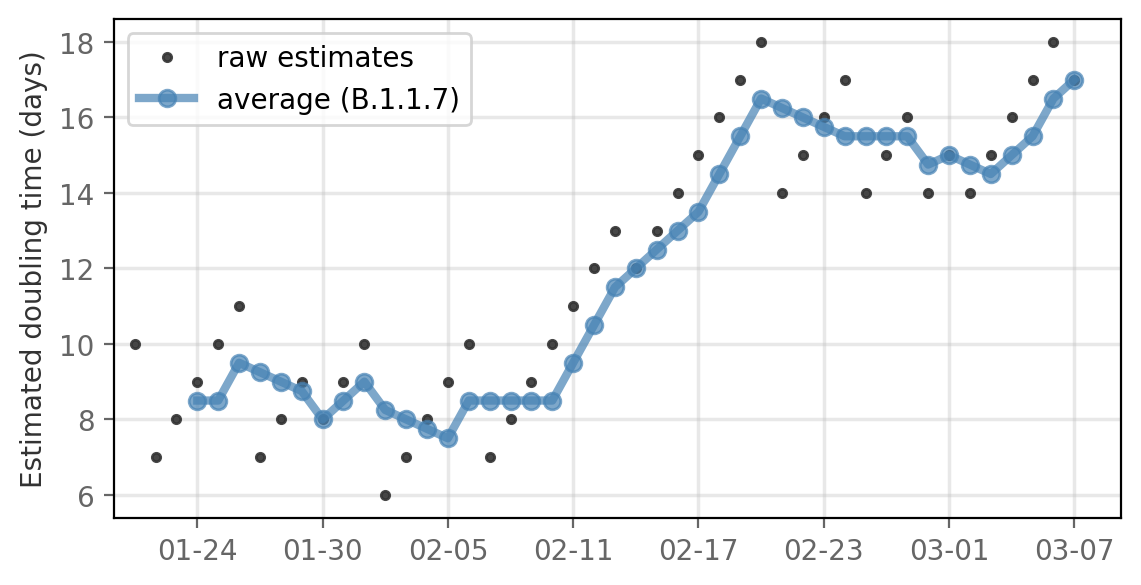

In [10]:
fig, ax = plt.subplots(1,1,figsize=(6.5,3.3),dpi=200)

test['total_cases_b117_2'] = test['total_cases_b117']/2
test = test.reset_index().iloc[:,1:]
start_ln = 13
dbls = []
for i in range(start_ln, test.shape[0]):
    val_i = test['total_cases_b117_2'].values[i]
    vals_j = [val_i - j for j in test['total_cases_b117']]
    days_ago = i - np.argmin(np.array(vals_j)**2)
    dbls.append(days_ago)
    
# plt.plot([date_dict[i] for i in range(13, test.shape[0])],
ax.plot([i for i in range(start_ln, test.shape[0])],
         pd.Series(dbls).rolling(window=1).mean().values, lw=0, marker='.',
         label='raw estimates', alpha=0.9, color='.2')
ax.plot([i for i in range(start_ln, test.shape[0])],
         pd.Series(dbls).rolling(window=4).mean().values, marker='o',lw=3,
         label='average (B.1.1.7)', alpha=0.7, color='steelblue')

ax.set_xticks(range(10,test['date'].shape[0],6))
ax.set_xticklabels([i[5:] for i in test['date'].values[10::6]])
ax.set_ylabel('Estimated doubling time (days)', color='.2')
ax.set_xlim(12)
ax.tick_params(labelcolor='.4', color='.4')
ax.grid(linewidth=1.25,color='.75',alpha=0.35)
ax.legend()

plt.savefig('../figs/pngs/estimated_doubling_time.png', dpi=425, bbox_inches='tight')
plt.show()

In [11]:
# var_w_df = var_w_df.merge(out_dfx, how='left', on=['state','week'])
var_w_df['state'] = [all_state_names[i.lower()] if i.lower() in list(all_state_names.keys())
                     else i for i in var_w_df['state']]
var_w_df = var_w_df.merge(state_pop, how='left', on='state')

variant_df['state'] = [all_state_names[i.lower()] if i.lower() in list(all_state_names.keys())
                       else i for i in variant_df['state']]
variant_df = variant_df.merge(state_pop, how='left', on='state')
variant_df

,date,state,total_cases_b117,total_cases_p1,total_cases_b1351,week,population
0,2021-01-08,Alaska,0.0,0.0,0.0,53,735132
1,2021-01-08,Alabama,0.0,0.0,0.0,53,4833722
2,2021-01-08,Arkansas,0.0,0.0,0.0,53,2959373
3,2021-01-08,Arizona,0.0,0.0,0.0,53,6626624
4,2021-01-08,California,32.0,0.0,0.0,53,38332521
...,...,...,...,...,...,...,...
1372,2021-03-07,Vermont,0.0,0.0,0.0,61,626630
1373,2021-03-07,Washington,70.0,0.0,5.0,61,6971406
1374,2021-03-07,Wisconsin,26.0,0.0,1.0,61,5742713
1375,2021-03-07,West Virginia,3.0,0.0,0.0,61,1854304


In [12]:
varout = []
for stlab in variant_df['state'].unique():
    var_w_dfX = variant_df.loc[variant_df['state']==stlab].copy()
    var_w_dfX['new_cases_b117'] = var_w_dfX['total_cases_b117'].diff()
    var_w_dfX['new_cases_p1'] = var_w_dfX['total_cases_p1'].diff()
    var_w_dfX['new_cases_b1351'] = var_w_dfX['total_cases_b1351'].diff()
    varout.append(var_w_dfX)
    
variant_df = pd.concat(varout).reset_index().iloc[:,1:]

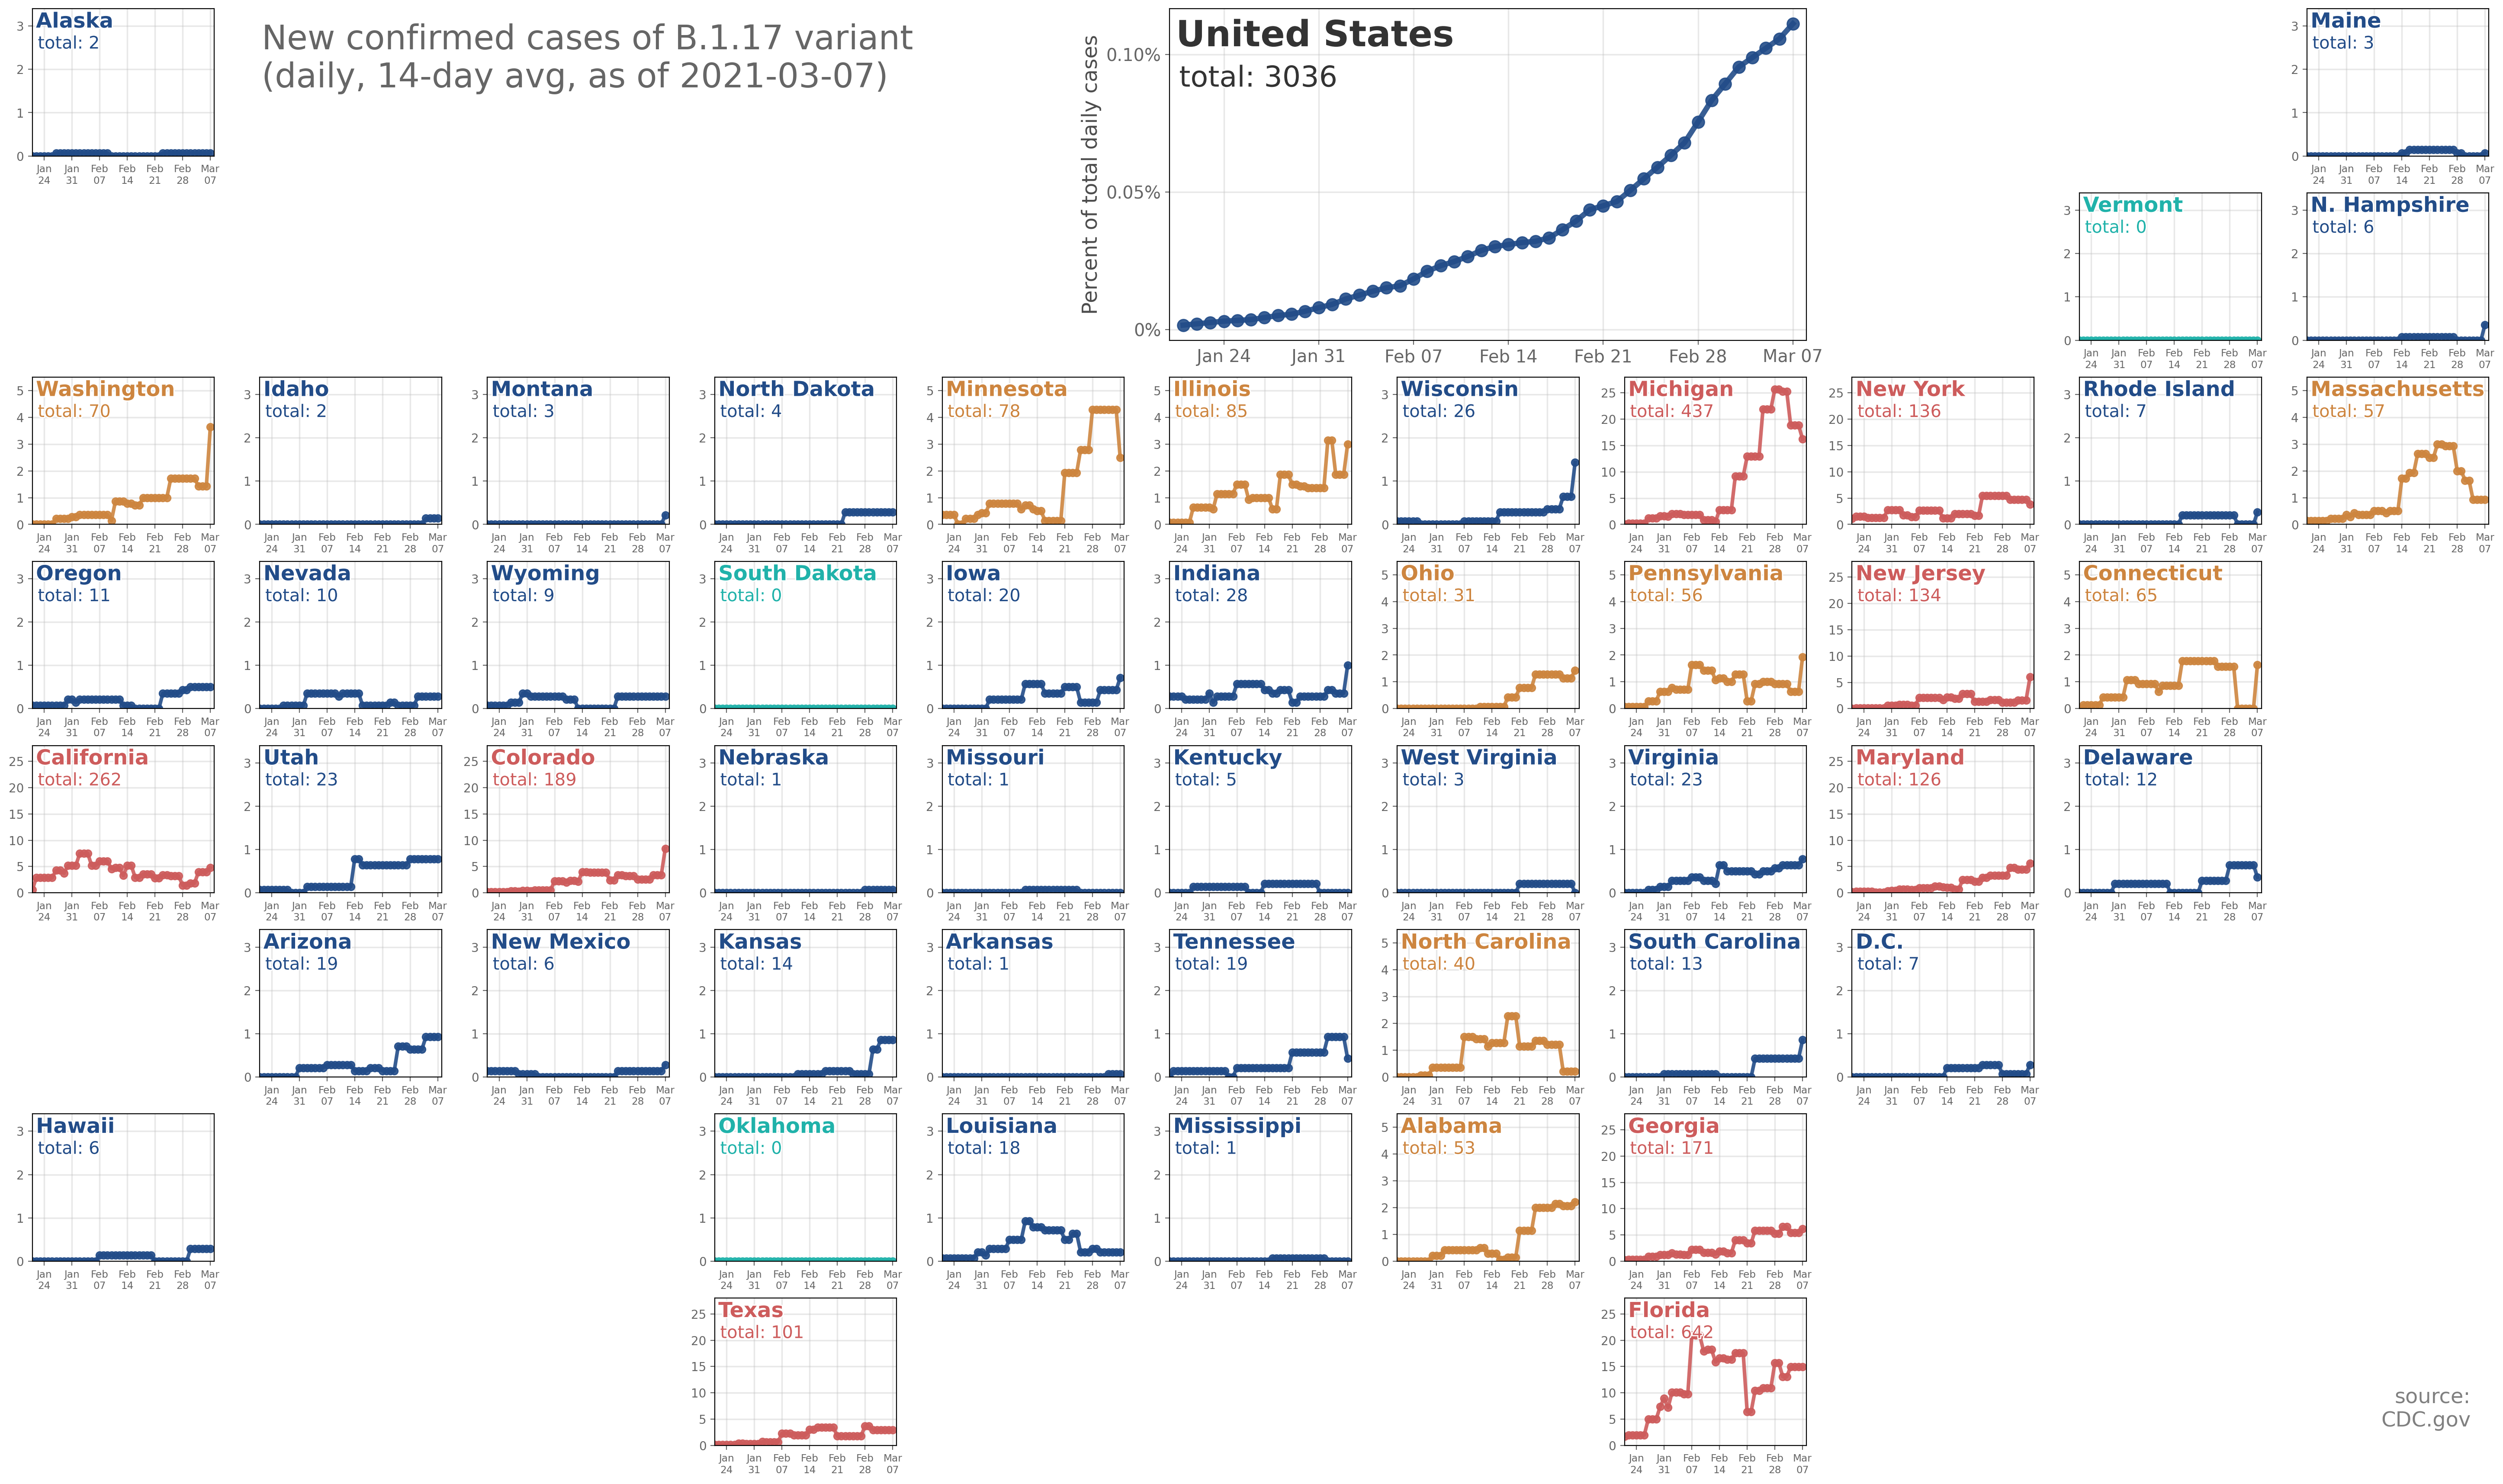

In [13]:
wid = 14

w = 3.33; h = 2.75
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=200)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.25)

for st, po in list(state_posx.items()):#[11:15]:
    if st in ['gu','pr','vi','mp']:
        ax[po].set_axis_off()
        continue
    stlab = all_state_names[st]
    var_w_dfX = variant_df.loc[variant_df['state']==stlab].copy()
    varX = DATE_DF.merge(var_w_dfX[['date','new_cases_b117', 'population']], how='left', on='date')
    varX['population'] = var_w_dfX['population'].values[0]
    varX['new_cases_b117'] = np.nan_to_num(varX['new_cases_b117'])
    varX['new_cases_b117'] = varX['new_cases_b117'].rolling(window=wid).mean().values
    varX = varX.loc[varX['date']>'2021-01-08'].copy()
    dates = varX['date'].values
    yvals_st = varX['new_cases_b117'].values
#     yvals_st = varX['new_cases_b117'].values / varX['population'] * 100000

    colx = down_col
    tot = int(variant_df.loc[variant_df['state']==stlab]['total_cases_b117'].values[-1])
    if tot > 0:
        colx = up_col
        if tot > 30:
            colx = 'peru'
            if tot > 100:
                colx = 'indianred'

    ax[po].plot([date_dict[i] for i in dates], yvals_st,
                color=colx, lw=lw, alpha=0.9, marker='o', markersize=6)

    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'New Hampshire':
        stlab = 'N. Hampshire'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana\nIslands'

    ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
                color=colx,fontweight='bold',transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])
    ax[po].text(0.03,0.82,"total: %i"%tot,fontsize='x-large',va='top',ha='left',
                color=colx,transform=ax[po].transAxes,
                path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                              path_effects.Normal()])

    ylim_st = ax[po].get_ylim()
    if tot > 30 and tot < 100:
        ylim_st = (0,5.5)
        ax[po].set_yticks([0, 1, 2, 3, 4, 5])
    elif tot >= 100:
        ylim_st = (0,28)
    else:
        ylim_st = (0,3.4)
        ax[po].set_yticks([0, 1, 2, 3])

    ax[po].tick_params(labelcolor='.4', color='.4')
    ax[po].set_xticks([date_dict[i] for i in dates[1::7]])
    ax[po].set_xticklabels([month_dict[i[5:7]]+'\n'+i[8:] for i in dates[1::7]], fontsize='small')
    ax[po].grid(linewidth=1.25,color='.75',alpha=0.35)
#     ax[po].set_ylim(0, 0.125)
    ax[po].set_ylim(ylim_st[0],ylim_st[1])
    ax[po].set_xlim(date_dict[dates[wid]]-2,
                    date_dict[dates[-1]]+1)

for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()


stlab = 'United States'
child_avg = []

gs = ax[1, 8].get_gridspec()
for a in ax[0:2, 5:8].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:2, 5:8])

var_w_dfX = variant_df.groupby('date').agg({'new_cases_b117':'sum',
                                            'population':'sum'}).reset_index()
varX = DATE_DF.merge(var_w_dfX[['date','new_cases_b117','population']], how='left', on='date')
ll = tdf.groupby('date').agg({'new_cases_7_day_rolling_average':np.nansum}).reset_index()

lllX = DATE_DF.merge(ll, how='left', on='date')
varX['population'] = var_w_dfX['population'].values[0]
varX['new_cases_b117'] = np.nan_to_num(varX['new_cases_b117'])
varX['new_cases_b117'] = varX['new_cases_b117'].rolling(window=wid).mean().values
lllX['new_cases'] = np.nan_to_num(lllX['new_cases_7_day_rolling_average'])
lllX['new_cases'] = lllX['new_cases'].rolling(window=wid).mean().values
varX = varX.loc[varX['date']>'2021-01-01'].copy()
testtt = varX.merge(lllX, how='left', on='date')
# testtt = testtt.loc[testtt['date']<today].copy()
dates = testtt['date'].values

yvals_st = testtt['new_cases_b117'].values /\
           testtt['new_cases'].rolling(window=wid).mean().values * 100

colx = up_col

axbig.plot([date_dict[i] for i in dates], pd.Series(yvals_st).rolling(window=7).mean().values,
            color=colx, lw=lw*1.5, alpha=0.9, marker='o', markersize=10)

axbig.text(0.01,0.97,stlab,fontsize=30,va='top',ha='left',
           color='.2',fontweight='bold',transform=axbig.transAxes,
           path_effects = [path_effects.Stroke(linewidth=2, foreground='w'), 
                           path_effects.Normal()])
tot = int(var_w_dfX['new_cases_b117'].sum()+\
          variant_df.loc[variant_df['date']=='2021-01-08']['total_cases_b117'].sum())
axbig.text(0.015,0.83,"total: %i"%tot,fontsize=24,va='top',ha='left',
            color='.2',transform=axbig.transAxes,
            path_effects=[path_effects.Stroke(linewidth=2, foreground='w'),
                          path_effects.Normal()])

ylim_st = axbig.get_ylim()
ylim_st = (ylim_st[0], np.nanmax(yvals_st)*1.05)
axbig.tick_params(labelcolor='.4', color='.4', labelsize='x-large')
axbig.set_yticks([0, 0.05, 0.1])#, 0.15])
axbig.set_yticklabels(["0%", "0.05%", '0.10%'])#, "0.15%"])
axbig.set_ylabel('Percent of total daily cases', color='.3', fontsize='xx-large')
axbig.set_xticks([date_dict[i] for i in dates[1::7]])
axbig.set_xticklabels([month_dict[i[5:7]]+' '+i[8:] for i in dates[1::7]])
axbig.grid(linewidth=1.25,color='.75',alpha=0.35)
# axbig.set_ylim(0, 0.031)
axbig.set_xlim(date_dict[dates[wid+7]]-3,
               date_dict[dates[-1]]+1)

ax[tups[-1]].text(0.9,0.1,'source:\nCDC.gov',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)

ax[(0,1)].text(0.01,0.9,"New confirmed cases of B.1.17 variant\n"+\
                         "(daily, %i-day avg, as of %s)"%(wid,variant_df['date'].max()),
               color='.4', fontsize=28, va='top', ha='left', transform=ax[(0,1)].transAxes)


plt.savefig('../figs/pngs/b117_cases.png', dpi=300, bbox_inches='tight')

plt.show()

# testing data

In [14]:
test_df = tdf.groupby(['date','state_name']).agg({'new_test_results_reported':'sum',
                                                  'new_test_results_reported_7_day_rolling_average':'sum'}).reset_index()
test_df = test_df.merge(state_pop.rename(columns={'state':'state_name'}),how='left',on='state_name')

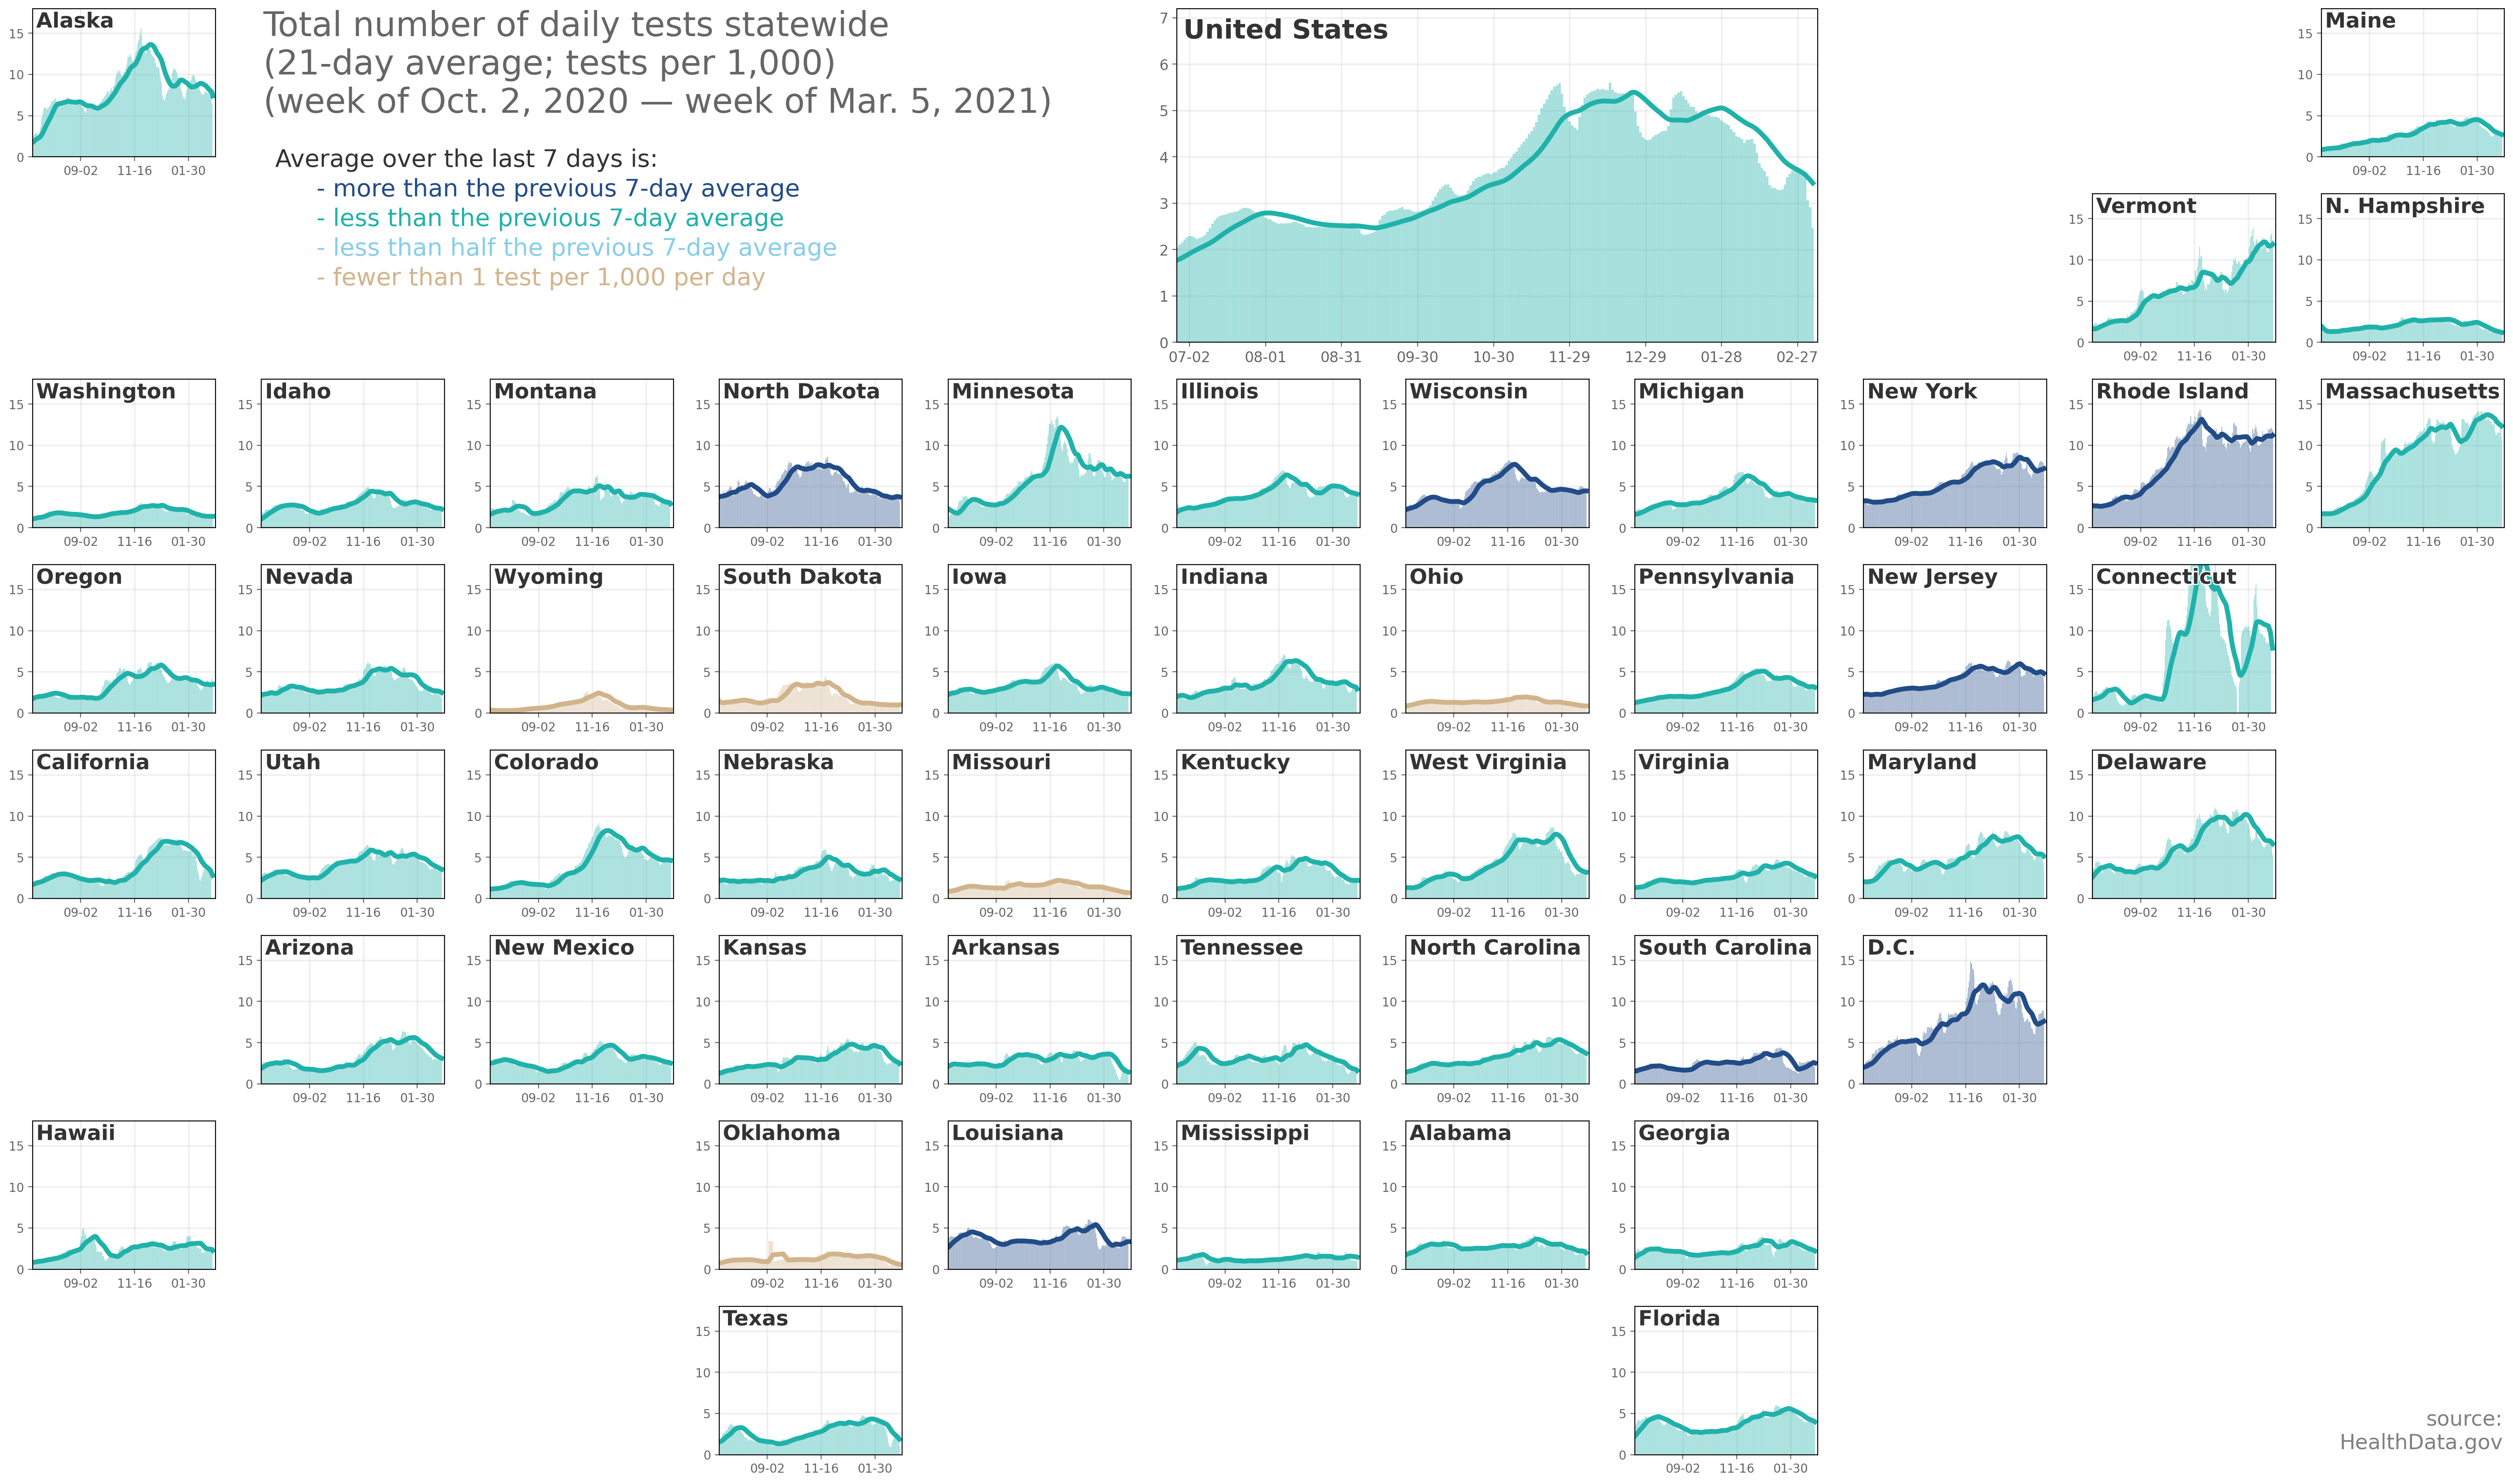

In [15]:
lw = 4
days_since = 7
min_c = 1
wid = 21

w = 3.33; h = 2.75
ncols = 11; nrows = 8
tups = list(it.product(range(nrows), range(ncols)))
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h), dpi=200)#, sharex=True)
plt.subplots_adjust(wspace=0.25,hspace=0.25)

for st, po in state_posx.items():
    stlab = all_state_names[st]
    if st in ['gu','vi','mp','pr']:
        ax[po].set_axis_off()
        continue

    st_df = test_df.loc[test_df['state_name']==stlab].copy()
    dates = st_df['date'].values
    st_df['new_tests_per1000'] = st_df['new_test_results_reported_7_day_rolling_average']/\
                                 st_df['population'] * 1000
    yvals_st = st_df['new_tests_per1000'].rolling(window=wid).mean().values
    yvals_st_raw = st_df['new_tests_per1000'].values
    
    recent_average_curr = np.nanmean(yvals_st[(-days_since):])
    recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

    if recent_average_prev >= recent_average_curr:
        col_co = down_col
    if recent_average_prev <= recent_average_curr:
        col_co = up_col
    if recent_average_prev >= 2*recent_average_curr:
        col_co = vdown_col
    if recent_average_curr < min_c:
        col_co = low_col

    ax[po].plot([date_dict[i] for i in dates], yvals_st, color=col_co, linewidth=lw)
    ax[po].bar([date_dict[i] for i in dates], yvals_st_raw, color=col_co,
               alpha=0.4, width=1, linewidth=0.1, ec='w')

    if stlab == 'District of Columbia':
        stlab = 'D.C.'
    if stlab == 'New Hampshire':
        stlab = 'N. Hampshire'
    if stlab == 'Northern Mariana Islands':
        stlab = 'N. Mariana\nIslands'

    text = ax[po].text(0.02,0.98,stlab,fontsize='xx-large',va='top',ha='left',
                color='.2',fontweight='bold',transform=ax[po].transAxes)
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                           path_effects.Normal()])

    ylim_st = ax[po].get_ylim()
    xlim_st = ax[po].get_xlim()
    ydiff = ylim_st[1]-ylim_st[0]
    ylim_st = (0, 18)
    ax[po].set_ylim(ylim_st[0], ylim_st[1])
    ax[po].set_xticks([j for i,j in list(date_dict.items())[20::75]])
    ax[po].set_xticklabels([i[5:] for i,j in list(date_dict.items())[20::75]], fontsize='medium')
    ax[po].set_xlim(date_dict['2020-06-28']-1,list(date_dict.values())[-1]+2)
    ax[po].tick_params(labelcolor='.4', color='.4')
    ax[po].grid(linewidth=1.25,color='.75',alpha=0.25)

for tup in tups:
    if tup not in state_posx.values():
        ax[tup].set_axis_off()


stlab = 'United States'

gs = ax[1, 8].get_gridspec()
for a in ax[0:2, 5:8].flatten():
    a.remove()
axbig = fig.add_subplot(gs[0:2, 5:8])

usa_df = test_df.groupby(['date']).agg({'new_test_results_reported_7_day_rolling_average':'sum',
                                        'population':'sum'}).reset_index()
usa_df['new_tests_per1000'] = usa_df['new_test_results_reported_7_day_rolling_average'] / usa_df['population'] * 1000
yvals_st = usa_df['new_tests_per1000'].rolling(window=wid).mean().values
yvals_st_raw = usa_df['new_tests_per1000'].values
dates = usa_df['date'].values

recent_average_curr = np.nanmean(yvals_st[(-days_since):])
recent_average_prev = np.nanmean(yvals_st[(-2*days_since):(-days_since)])

if recent_average_prev >= recent_average_curr:
    col_co = down_col
if recent_average_prev <= recent_average_curr:
    col_co = up_col
if recent_average_prev >= 2*recent_average_curr:
    col_co = vdown_col
if recent_average_curr < min_c:
    col_co = low_col

axbig.plot([date_dict[i] for i in dates], yvals_st, color=col_co, linewidth=lw)
axbig.bar([date_dict[i] for i in dates], yvals_st_raw, color=col_co,
          alpha=0.4, width=1, linewidth=0.1, ec='w')

text = axbig.text(0.01,0.97,stlab,fontsize=22,va='top',ha='left',
            color='.2',fontweight='bold',transform=axbig.transAxes)
text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='w'),
                       path_effects.Normal()])

ylim_st = axbig.get_ylim()
xlim_st = axbig.get_xlim()
ydiff = ylim_st[1]-ylim_st[0]
ylim_st = (0,7.2)
axbig.set_ylim(ylim_st[0], ylim_st[1])
axbig.tick_params(labelcolor='.4', color='.4', labelsize='large')
axbig.set_xticks([date_dict[i] for i in dates[::30]])
axbig.set_xticklabels([i[5:] for i in dates[::30]])
axbig.set_xlim(date_dict['2020-06-28']-1,date_dict[dates[-1]]+2)
axbig.grid(linewidth=1.25,color='.75',alpha=0.25)

ax[tups[-1]].text(0.99,0.01,'source:\nHealthData.gov',color='.5',fontsize='xx-large',
                va='bottom', ha='right', transform=ax[tups[-1]].transAxes)
ax[(0,1)].text(0.01,0.99,"Total number of daily tests statewide\n"+\
                         "(%i-day average; tests per 1,000)\n"%wid+\
                         "(week of Oct. 2, 2020 — week of %s. %i, 2021)"%(month_dict[dates[-1][5:7]],
                                                                          int(dates[-1][8:])),
               color='.4', fontsize=28, va='top', ha='left', transform=ax[(0,1)].transAxes)
ax[(1,1)].text(0.075,1.15,'Average over the last %i days is:'%(days_since),
                color='.2',fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.95,'- more than the previous %i-day average'%(days_since),
                color=up_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.75,'- less than the previous %i-day average'%(days_since),
                color=down_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.55,'- less than half the previous %i-day average'%(days_since),
                color=vdown_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)
ax[(1,1)].text(0.3,0.35,'- fewer than %i test per 1,000 per day'%(min_c),
                color=low_col,fontsize=20, va='bottom', ha='left', transform=ax[(1,1)].transAxes)

plt.savefig('../figs/pngs/state_subplot_daily_testcounts_per1000.png', dpi=300, bbox_inches='tight')

plt.show()

____________